### Linear Regression

[Source code is here.](https://github.com/jackgreenburg/jackgreenburg.github.io/blob/main/posts/linear-regression/linreg.py)

In this blog post I have implemented linear regression.

In [1]:
from linreg import LinearRegression # your source code

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def draw_line(w, x_min, x_max, *, color="black", ax=None, alpha=1, **kwargs):
  x = np.linspace(x_min, x_max, 101)
  if len(w) == 3:
    y = -(w[0]*x + w[2])/w[1]
  elif len(w) == 2:
    y = w[0]*x + w[1]
  if ax is None:
    plt.plot(x, y, color = color, alpha=alpha, **kwargs)
  else:
    ax.plot(x, y, color = color, alpha=alpha, **kwargs)

In [3]:
def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val


Analytical method:
Training score = 0.5398
Validation score = 0.5187

Gradient method:
Training score = 0.5398
Validation score = 0.5187


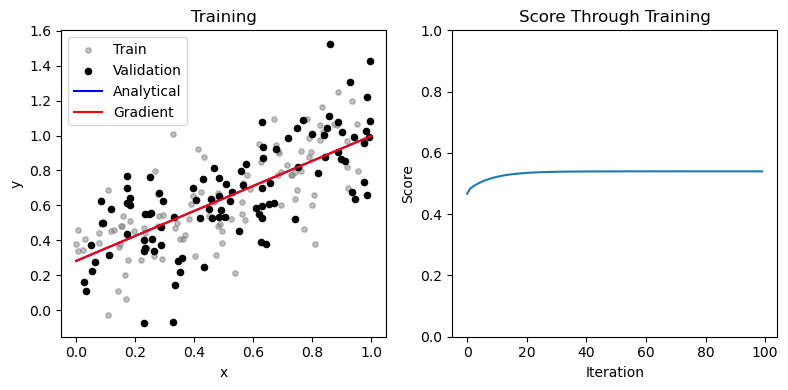

In [4]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# train
LR_analytical = LinearRegression()
LR_analytical.fit_analytical(X_train, y_train) 
LR_gradient = LinearRegression()
LR_gradient.fit_gradient(X_train, y_train, w=[.5, .5], max_steps=100, alpha=.005)

# plot best fit lines
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))
axarr[0].scatter(X_train, y_train, color="gray", alpha=.5, label="Train", s=15)
axarr[0].scatter(X_val, y_val, color="black", alpha=1, label="Validation", s=20)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")

draw_line(LR_analytical.w, 0, 1, color="blue",  ax=axarr[0], label="Analytical")
draw_line(LR_gradient.w, 0, 1, color="red", ax=axarr[0], label="Gradient")
axarr[0].legend()

# plot score
axarr[1].plot(LR_gradient.score_history)
labels = axarr[1].set(xlabel = "Iteration", ylabel = "Score", title = "Score Through Training")
axarr[1].set_ylim([0, 1])

plt.tight_layout()

print("\nAnalytical method:")
print(f"Training score = {LR_gradient.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR_gradient.score(X_val, y_val).round(4)}")

print("\nGradient method:")
print(f"Training score = {LR_gradient.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR_gradient.score(X_val, y_val).round(4)}")

## Experiments

### Experiments 1 and 2: Many Features and LASSO Regularization

In this experiment we will increase the number of features up to `n - 1` in order to study what happens to the training and validation scores.

We will also add a regularizing term to our loss function in order fight against overfitting when the number of features is very high.

Scores with 100 training samples and 99 features:
Training score = 1.0
Validation score = -12.1924

Scores while using modified loss function with regularization term:
Training score = 0.9984
Validation score = 0.8099


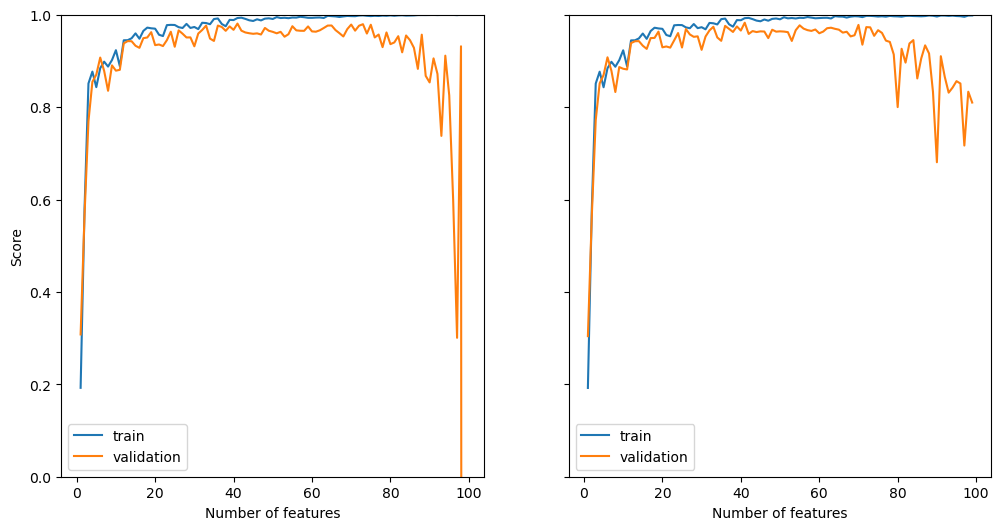

In [19]:
from sklearn.linear_model import Lasso

n_train = 100
n_val = 100
noise = 0.2
scores = []
scores_lasso = []
for i in range(1, n_train):
    p_features = i

    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

    LR = LinearRegression()
    LR.fit_analytical(X_train, y_train)     
    
    LR_lasso = Lasso(alpha = 0.001)
    LR_lasso.fit(X_train, y_train)
    
    scores.append({"train": LR.score(X_train, y_train), "validation": LR.score(X_val, y_val)})
    scores_lasso.append({"train": LR_lasso.score(X_train, y_train), "validation": LR_lasso.score(X_val, y_val)})

# plot score
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

scores_df = pd.DataFrame(scores)
scores_df.index = np.arange(1, len(scores_df) + 1)
scores_df.plot(ax=ax0, xlabel="Number of features", ylabel="Score")
ax0.set_ylim([0, 1])

scores_lasso_df = pd.DataFrame(scores_lasso)
scores_lasso_df.index = np.arange(1, len(scores_lasso_df) + 1)
scores_lasso_df.plot(ax=ax1, xlabel="Number of features", ylabel="Score")

print(f"Scores with {n_train} training samples and {n_train-1} features:")
print(f"Training score = {round(scores[-1]['train'], 4)}")
print(f"Validation score = {round(scores[-1]['validation'], 4)}")

print(f"\nScores while using modified loss function with regularization term:")
print(f"Training score = {round(scores_lasso[-1]['train'], 4)}")
print(f"Validation score = {round(scores_lasso[-1]['validation'], 4)}")

As we can clearly see, our implementation becomes **severely overfit** as the number of features approaches the number of training examples. The training score approaches near perfection, whereas the validation score gets worse. 

The scikit-learn implementation with the regularization term also exhibits some pretty serious overfitting, but not to the same degree as our implementation. When the number of features is nearly equal to the number of training examples, the regularization term is able to keep the validation score from tanking.


### Experiment 3: Bike Share Data

In this experiment we will train a model to predict the number of riders of a bikesharing program in DC.

Training score = 0.7318
Validation score = 0.6968


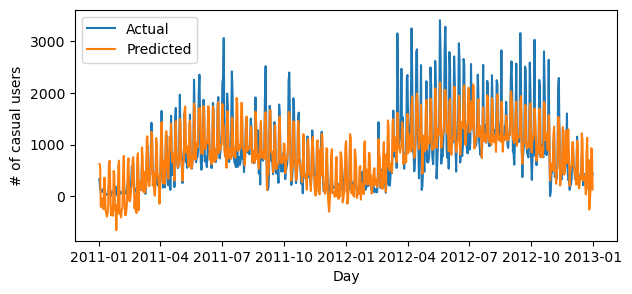

In [65]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("https://philchodrow.github.io/PIC16A/datasets/Bike-Sharing-Dataset/day.csv")

cols = ["casual", 
        "mnth", 
        "weathersit", 
        "workingday",
        "yr",
        "temp", 
        "hum", 
        "windspeed",
        "holiday"]

bikeshare = data[cols]
bikeshare = pd.get_dummies(bikeshare, columns = ['mnth'], drop_first = "if_binary")

train, test = train_test_split(bikeshare, test_size = .2, shuffle = False)

X_train = train.drop(["casual"], axis = 1)
y_train = train["casual"]

X_test = test.drop(["casual"], axis = 1)
y_test = test["casual"]

LR = LinearRegression()
LR.fit_analytical(X_train, y_train)

preds = LR.predict(bikeshare.drop(["casual"], axis=1))

fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(pd.to_datetime(data['dteday']), data['casual'], label="Actual")
ax.plot(pd.to_datetime(data['dteday']), preds, label="Predicted")
ax.set(xlabel = "Day", ylabel = "# of casual users")
ax.legend()

print(f"Training score = {LR.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR.score(X_test, y_test).round(4)}")


In [58]:
print("Weights for each feature")
for i, (key, weight) in enumerate(zip(bikeshare.keys()[1:], LR.w)):
    print(f" {i+1}. {key}: {weight}")


Weights for each feature
 1. weathersit: -108.37113626599087
 2. workingday: -791.6905491329867
 3. yr: 280.58692732526924
 4. temp: 1498.7151127165637
 5. hum: -490.10033978027354
 6. windspeed: -1242.8003807505336
 7. holiday: -235.8793491765524
 8. mnth_2: -3.3543971201747707
 9. mnth_3: 369.2719555186909
 10. mnth_4: 518.4087534451241
 11. mnth_5: 537.3018861590382
 12. mnth_6: 360.8079981484559
 13. mnth_7: 228.88148124909466
 14. mnth_8: 241.3164120150012
 15. mnth_9: 371.50385386758205
 16. mnth_10: 437.6008478681119
 17. mnth_11: 252.43300404938137
 18. mnth_12: 90.8214604976828


#### Examining the weights:

We can see that our model found temperature to be the single largest factor in determining number of riders. It gave negative weights to weekdays and surprisingly holidays as well. The warmer months have higher weights than the winter months, but early spring and fall have higher weights than summer does. I believe that the temperature weight compensates for the lower weights of the summer months to make it so the model still predicts the highest ridership numbers during the summer. This makes sense, since every day during the summer in DC is hot... The year also was given a positive weight, reflecting the higher ridership numbers in 2012 compared to 2011.